In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
years = 5
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

In [4]:
plotdepths = mymesh.gdept_1d[0,:34]

plotdepths = np.append(0,plotdepths)

In [5]:
def get_data(mydata, section, starttime, endtime):
#     lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer1 = mydata.final_temp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer2 = mydata.final_salt[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, tracer1, tracer2

In [6]:
def get_all_data_SoG(folder):
    yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
    starttime = 1
    endtime = 720

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0

    #2016 and 2017
    year = [16,17]

    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=12

    #2019 and 2018 (both done month by month)
    year = [18,19]
    for num in year:
        k += 12
        for i in range(len(str_mo)):
            file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/'+'forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
            mydata = xr.open_dataset(file)
            time = mydata.init_t[-1]

            for section in sections:
                depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
                tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
                tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
                transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
                month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

In [7]:
back_mo = ['31jan','03mar','31mar','01may','31may','01jul','31jul','31aug','01oct','31oct','01dec','31dec']

def BACK_get_all_data_SoG(folder):
    yearjumps = [0,1,0,1,1,0,1,0,1,-2,1,0]
    starttime = 721
    endtime = 1440

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0
    
    #2016 (month by month)
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'16/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/720)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2017 and 2018
    k=12
    year = [17,18]
    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=24

    #2019 and (month by month)
    k=36
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'19/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/720)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))
    
    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

Text(0, 0.5, 'Depth (m)')

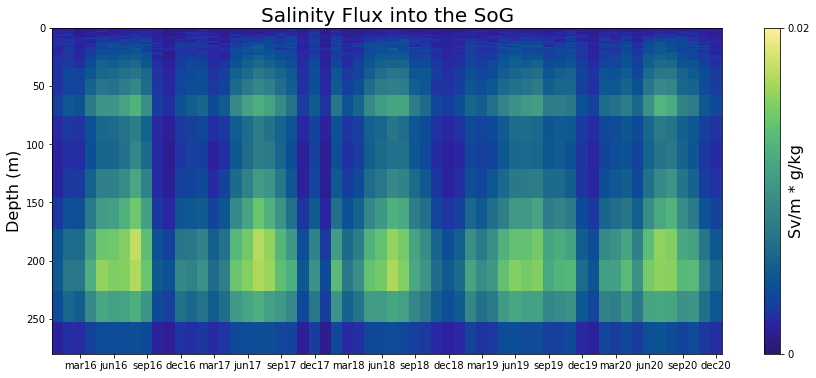

In [8]:
folder = 'Car_Sal'
Car_Sal_depths, Car_Sal_transports, carbon, salinity, Car_Sal_month = get_all_data_SoG(folder)
month_edge = np.arange(0.5,61.5,1)

transports = Car_Sal_transports * (10**-6) #convert to Sv
vmax = (0.02/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Car_Sal_month, Car_Sal_depths, salinity, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.haline
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),2)])
cb1.set_label('Sv/m * g/kg', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Salinity Flux into the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

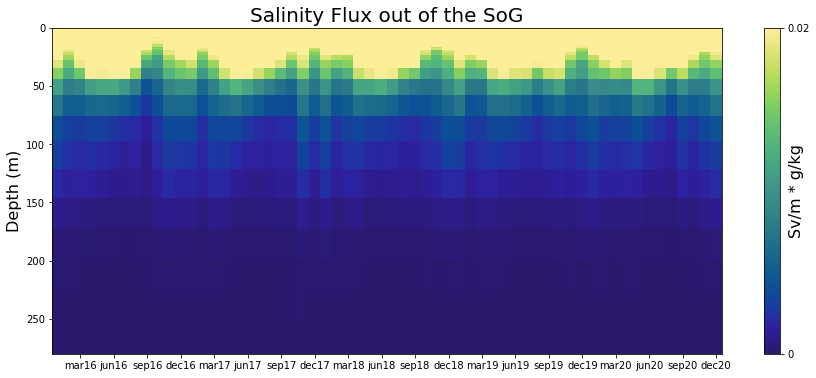

In [9]:
folder = 'Car_Sal'
BACK_Car_Sal_depths, BACK_Car_Sal_transports, Bcarbon, Bsalinity, BACK_Car_Sal_month = BACK_get_all_data_SoG(folder)
month_edge = np.arange(0.5,61.5,1)

transports = BACK_Car_Sal_transports * (10**-6) #convert to Sv
vmax = (0.02/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, Bsalinity, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.haline
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),2)])
cb1.set_label('Sv/m * g/kg', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Salinity Flux out of the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

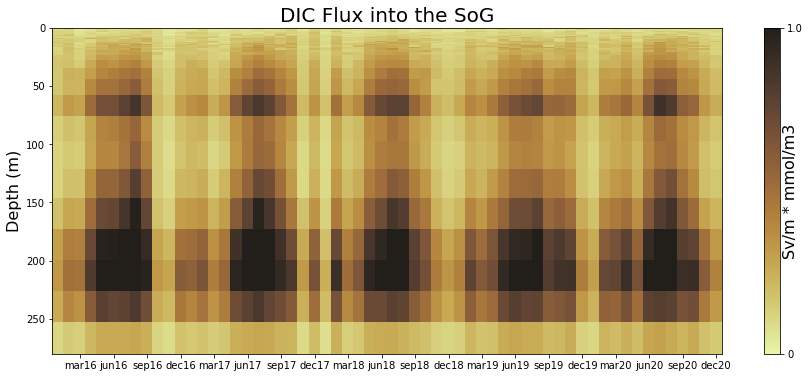

In [10]:
transports = Car_Sal_transports * (10**-6) #convert to Sv
vmax = (1/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Car_Sal_month, Car_Sal_depths, carbon, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.turbid
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),2)])
cb1.set_label('Sv/m * mmol/m3', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('DIC Flux into the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

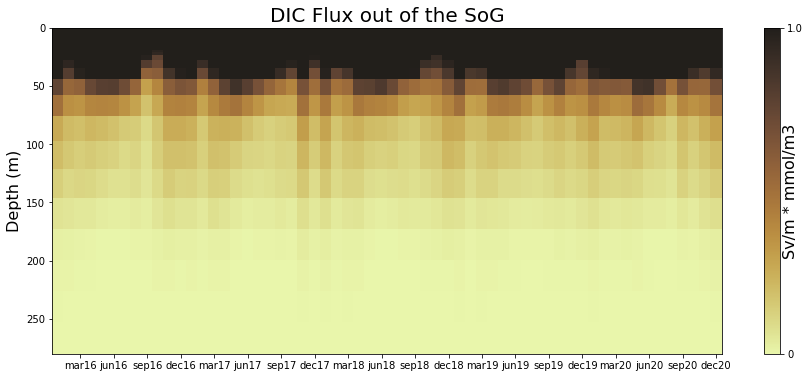

In [11]:
transports = BACK_Car_Sal_transports * (10**-6) #convert to Sv
vmax = (1/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, Bcarbon, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.turbid
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),2)])
cb1.set_label('Sv/m * mmol/m3', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('DIC Flux out of the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

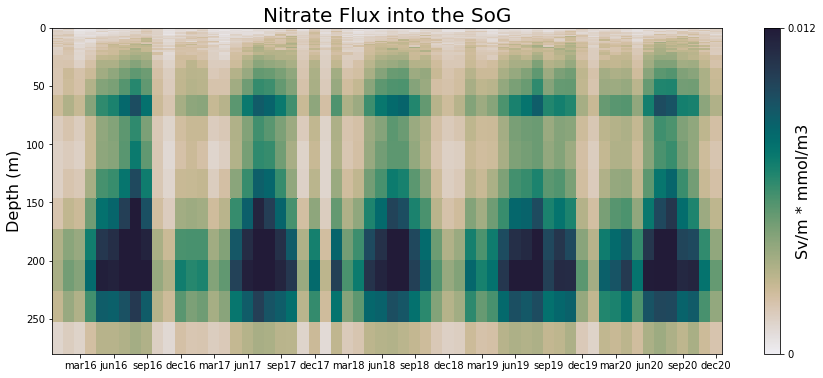

In [12]:
folder = 'Nit_Sil'
Nit_Sil_depths, Nit_Sil_transports, nitrate, silicon, Nit_Sil_month = get_all_data_SoG(folder)
month_edge = np.arange(0.5,61.5,1)

transports = Nit_Sil_transports * (10**-6) #convert to Sv
vmax = (0.012/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Nit_Sil_month, Nit_Sil_depths, nitrate, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.rain
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),3)])
cb1.set_label('Sv/m * mmol/m3', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Nitrate Flux into the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

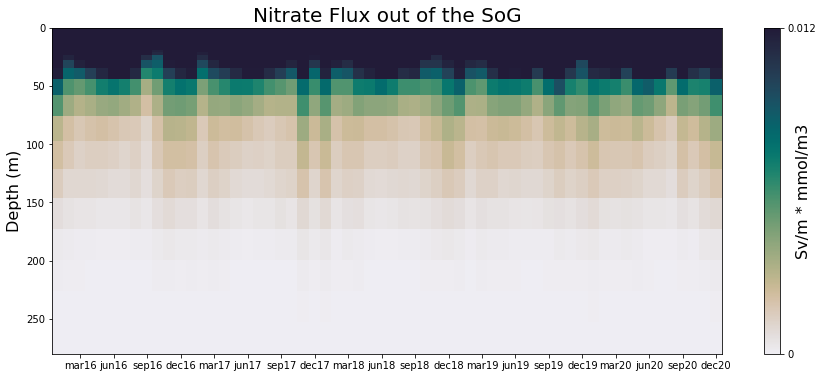

In [13]:
folder = 'Nit_Sil'
BACK_Nit_Sil_depths, BACK_Nit_Sil_transports, Bnitrate, Bsilicon, BACK_Nit_Sil_month = BACK_get_all_data_SoG(folder)
month_edge = np.arange(0.5,61.5,1)

transports = BACK_Nit_Sil_transports * (10**-6) #convert to Sv
vmax = (0.012/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, Bnitrate, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.rain
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),3)])
cb1.set_label('Sv/m * mmol/m3', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Nitrate Flux out of the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

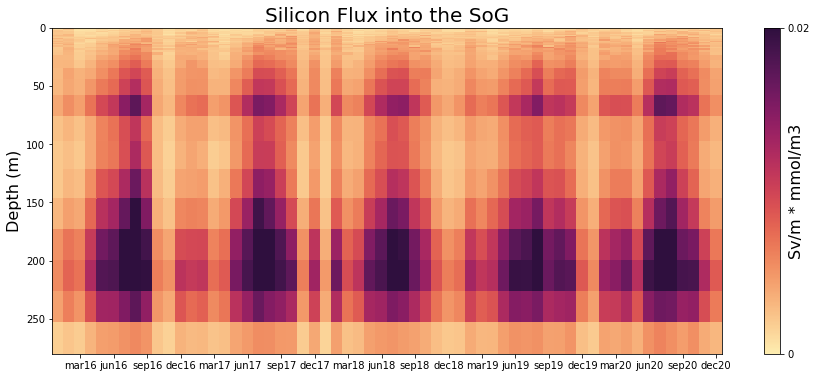

In [14]:
transports = Nit_Sil_transports * (10**-6) #convert to Sv
vmax = (0.02/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Nit_Sil_month, Nit_Sil_depths, silicon, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.matter
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),2)])
cb1.set_label('Sv/m * mmol/m3', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Silicon Flux into the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

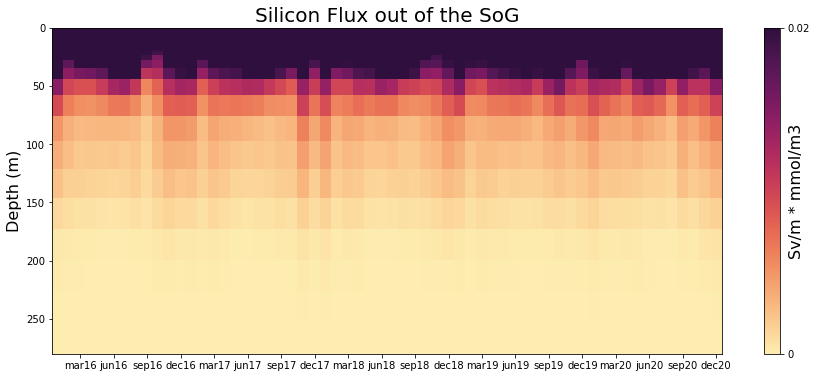

In [15]:
transports = BACK_Nit_Sil_transports * (10**-6) #convert to Sv
vmax = (0.02/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins=[month_edge,plotdepths] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, Bsilicon, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * H.statistic.T
H_final= H1.T * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.matter
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),2)])
cb1.set_label('Sv/m * mmol/m3', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Silicon Flux out of the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

## Net flux into the SoG

In [16]:
#forward Salinity and Carbon
d = {'carbon': carbon, 'salinity': salinity, 'transport': Car_Sal_transports, 'month':Car_Sal_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_for = np.array([])
carb_sum_for = np.array([])
trans_sum_for = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    trans_sum_for = np.append(trans_sum_for,sum(transports))
    carb_sum_for = np.append(carb_sum_for,sum(tracerC*transports)/1000*(44.01/1000))
    saln_sum_for = np.append(saln_sum_for,sum(tracerSa*transports))  

In [17]:
#backward Salinity and Carbon
d = {'carbon': Bcarbon, 'salinity': Bsalinity, 'transport': BACK_Car_Sal_transports, 'month':BACK_Car_Sal_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_back = np.array([])
carb_sum_back = np.array([])
trans_sum_back = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    trans_sum_back = np.append(trans_sum_back,sum(transports))
    carb_sum_back = np.append(carb_sum_back,sum(tracerC*transports)/1000*(44.01/1000))
    saln_sum_back = np.append(saln_sum_back,sum(tracerSa*transports))  

In [18]:
#forward Nitrate and Silicon
d = {'nitrate': nitrate, 'silicon': silicon, 'transport': Nit_Sil_transports, 'month':Nit_Sil_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_for = np.array([])
sili_sum_for = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_for = np.append(nitr_sum_for,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_for = np.append(sili_sum_for,sum(tracerSi*transports)/1000*(60.08/1000))

In [19]:
#backward Nitrate and Silicon
d = {'nitrate': Bnitrate, 'silicon': Bsilicon, 'transport': BACK_Nit_Sil_transports, 'month':BACK_Nit_Sil_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_back = np.array([])
sili_sum_back = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_back = np.append(nitr_sum_back,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_back = np.append(sili_sum_back,sum(tracerSi*transports)/1000*(60.08/1000))

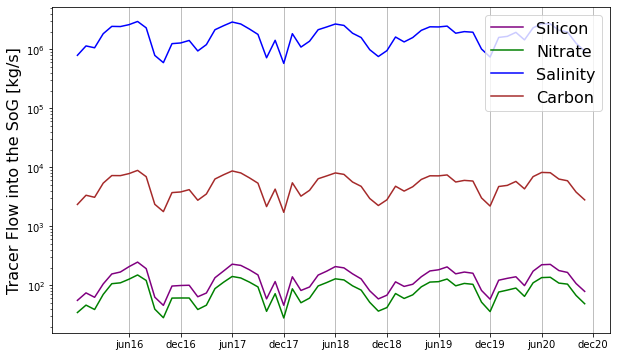

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(sili_sum_for,label='Silicon', c='purple')
ax.plot(nitr_sum_for,label='Nitrate', c='green')
ax.plot(saln_sum_for,label='Salinity', c='b')
ax.plot(carb_sum_for,label='Carbon', c='brown')

ax.legend(fontsize = 16)
# ax.set_ylim([-200,200])
ax.set_yscale('log')
ax.set_xticks(np.arange(6,61,6))
ax.set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
# ax.set_xlim(-0.2,len(str_mo)-0.8)
ax.set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax.grid(axis='x', which='both')

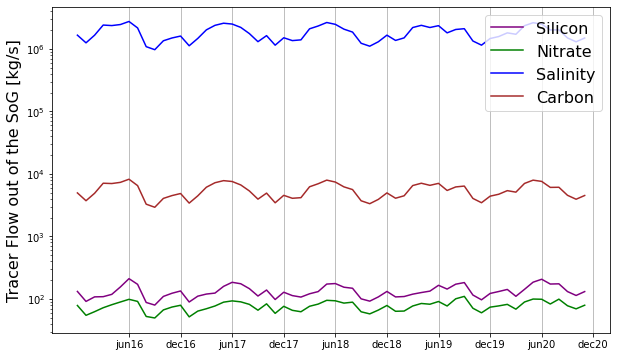

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(sili_sum_back,label='Silicon', c='purple')
ax.plot(nitr_sum_back,label='Nitrate', c='green')
ax.plot(saln_sum_back,label='Salinity', c='b')
ax.plot(carb_sum_back,label='Carbon', c='brown')

ax.legend(fontsize = 16)
# ax.set_ylim([-200,200])
ax.set_yscale('log')
ax.set_xticks(np.arange(6,61,6))
ax.set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
# ax.set_xlim(-0.2,len(str_mo)-0.8)
ax.set_ylabel('Tracer Flow out of the SoG [kg/s]', fontsize = 16)
ax.grid(axis='x', which='both')

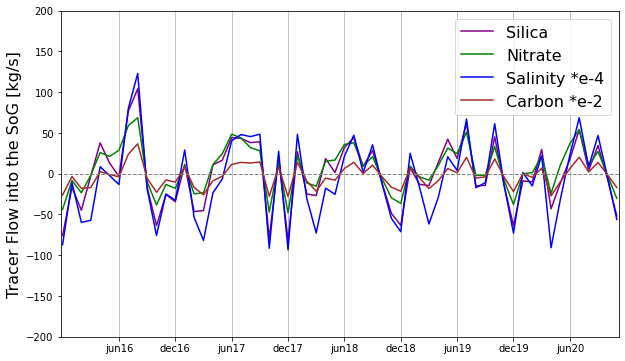

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(sili_sum_for-sili_sum_back,label='Silica', c='purple')
ax.plot(nitr_sum_for-nitr_sum_back,label='Nitrate', c='green')
ax.plot((saln_sum_for-saln_sum_back)/10000,label='Salinity *e-4', c='b')
ax.plot((carb_sum_for-carb_sum_back)/100,label='Carbon *e-2', c='brown')

ax.plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax.legend(fontsize = 16)
ax.set_ylim([-200,200])
# ax.set_yscale('log')
ax.set_xticks(np.arange(6,61,6))
ax.set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax.set_xlim(-0.2,60-0.8)
ax.set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax.grid(axis='x', which='both')

In [23]:
#same get data function but for initial instead of final
def get_data_init(mydata, section, starttime, endtime):
#     lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.init_z[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer1 = mydata.init_temp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer2 = mydata.init_salt[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, tracer1, tracer2

In [24]:
def get_all_data_SoG_init(folder):
    yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
    starttime = 1
    endtime = 720

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0

    #2016 and 2017
    year = [16,17]

    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data_init(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=12

    #2019 and 2018 (both done month by month)
    year = [18,19]
    for num in year:
        k += 12
        for i in range(len(str_mo)):
            file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/'+'forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
            mydata = xr.open_dataset(file)
            time = mydata.init_t[-1]

            for section in sections:
                depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0])
                tracer1 = np.append(tracer1, mydata.init_temp[(mydata.final_section==section)])
                tracer2 = np.append(tracer2, mydata.init_salt[(mydata.final_section==section)])
                transports = np.append(transports, mydata.init_transp[(mydata.final_section==section)]/time)
                month = np.append(month, np.full(len(mydata.init_salt[(mydata.final_section==section)]),i+k+1))

    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data_init(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month